First import all neccessary modules

In [1]:
from datetime import datetime
from preprocessor import Preprocessor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.metrics import Accuracy, Precision, Recall
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from message_encoder import *
from keras.optimizers import Adam, RMSprop, SGD, Nadam
import os
import sys
import tensorflow as tf
tf.config.run_functions_eagerly(True)

In [ ]:
save_artifacts = True

# Preprocessor
First we define all hyperparameters used for the preprocessor. If a preprocessor path is defined, the preprocesor will be loaded from that file instead of creating a new preprocessor since that might take a while. 

In [2]:
# hyper parameters
# preprocessing
log_files = [i for i in range(745, 754)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # How many datapoints per class should be collected if available
window_size = 20                                    # how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # size to be passed to the message_encoder, note that this is not neccessairily the shape of the output
message_encoder = BERTEncoder(encoding_output_size) # the message_encoder to be used. Can be TextVectorizationEncoder (uses keras.layers.TextVectorizer), BERTEncoder (only uses the BERT tokenizer) or BERTEmbeddingEncoder (also uses the BERT model)
extended_datetime_features = False                  # bool, whether the preprocessing should use a multitude of normalized features extracted from the date 
# preprocessor_file = r"C:\Users\Askion\Documents\agmge\log-classification\data\preprocessors\preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip" # if this is a string with content, load the file instead of creating a new preprocessor
preprocessor_file = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"


In the next block data is loaded and preprocessed either using a new preprocessor with the parameters above or using a preprocessor loaded from a file. The former might take a while depending on number and size of the log files. 

In [3]:
# preprocessing
if os.path.isfile(preprocessor_file):
    print("loading preprocessor from file...")
    pp = Preprocessor.load(preprocessor_file)
else:
    pp = Preprocessor(log_files, 
                    message_encoder, 
                    logs_per_class=logs_per_class, 
                    window_size=window_size, 
                    extended_datetime_features=extended_datetime_features, 
                    volatile=True)
    pp.preprocess()

    # save the dataset if it doesn't exist already!
    path = f"./data/preprocessors/preprocessor_{len(pp.loaded_files)}files_"
    m = "BERTenc" if isinstance(pp.message_encoder, BERTEncoder) else "BERTemb" if isinstance(pp.message_encoder, BERTEmbeddingEncoder) else "TextVec" if isinstance(pp.message_encoder, TextVectorizationEncoder) else "enc"
    path += f"_{logs_per_class}lpc_{window_size}ws_{m}x{encoding_output_size}"
    if extended_datetime_features: path += "_extdt"
    path += ".json"
    if not os.path.isfile(path):
        pp.save(path)


loading preprocessor from file...


# LSTM Architecture
Next we define the hyperparameters used by the LSTM architecture. 

In [ ]:
# lstm architecture
lstm_layers = 1                                     # int, how many lstm layers to use
lstm_units_per_layer = 50                           # int, how many lstm units per layer to use
dropout = 0                                       # float, which dropout value to use, 0.0 is equivalent to not using any dropout
recurrent_dropout = 0                             # float, same as with regular dropout

Then we can create the model itself using the parameters. The LSTM model is built as a sequential model. 

In [ ]:
# lstm architecture
model = Sequential()
input_shape = pp.data.entry_shape

model.add(Input(shape=input_shape))

# First LSTM layer
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
else:
    model.add(LSTM(lstm_units_per_layer, dropout=dropout, recurrent_dropout=recurrent_dropout))  # single layer, no sequences returned
# Intermediate LSTM layers (if any)
for i in range(lstm_layers - 2):
    model.add(LSTM(lstm_units_per_layer, return_sequences=True, dropout=dropout, recurrent_dropout=recurrent_dropout))
# Last LSTM layer (no return_sequences, output fed into Dense)
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer, dropout=dropout, recurrent_dropout=recurrent_dropout))

# Dense Layer
num_classes = len(set(y_train))
model.add(Dense(num_classes, activation='softmax'))


# Training
Next we define the training parameters and split the data into unlabeled, labeled and test data. The unlabeled data currently is just extracted from the dataset while discarding the labels. That is done in order to assure that the class ratios can stay the same. 

In [ ]:
# training hyperparameters
split_ratios = (4, 1)                               # percantage of the collected data that should be used for testing rather than training
epochs = 1000                                       # number of iterations to train
batch_size = 32                                     # int, number of samples processed before updating the model weights.
early_stopping_monitor = "val_loss"                 # what value to monitor for early_stopping. can be 'loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'recall', 'val_recall', 'f1_score', 'val_f1_score'
early_stopping_patience = 50                        # int, number of epochs to wait after no improvement, if this is greater than epochs, EarlyStopping will not apply
early_stopping_restore_best = True                  # bool, if true keeps the best weights, not the final ones.
validation_split = 0.2
learning_rate = 0.001                               # float to specify learning rate of the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer, can be one of Adam, RMSprop, SGD (can have momentum parameter), Nadam

# defining data for training and testing
train, test = pp.data.stratified_split((4, 1))
X_train, y_train = train
X_test, y_test = test
input_shape = pp.data.entry_shape
num_classes = len(set(y_train))

filename = f"../models/lstm_{lstm_layers}x{lstm_units_per_layer}_drop{dropout}_rec{recurrent_dropout}_lr{learning_rate}_bs{batch_size}_ep{epochs}_earlystp{early_stopping_monitor}{early_stopping_patience}{early_stopping_restore_best}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

Compile the model

In [ ]:
# compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# train the model
early_stopping = EarlyStopping(monitor=early_stopping_monitor, 
                               patience=early_stopping_patience, 
                               restore_best_weights=early_stopping_restore_best)

train the model

In [ ]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])

# Evaluating and Testing
Plot loss, validation loss, accuracy and validation accuracy of the training process.

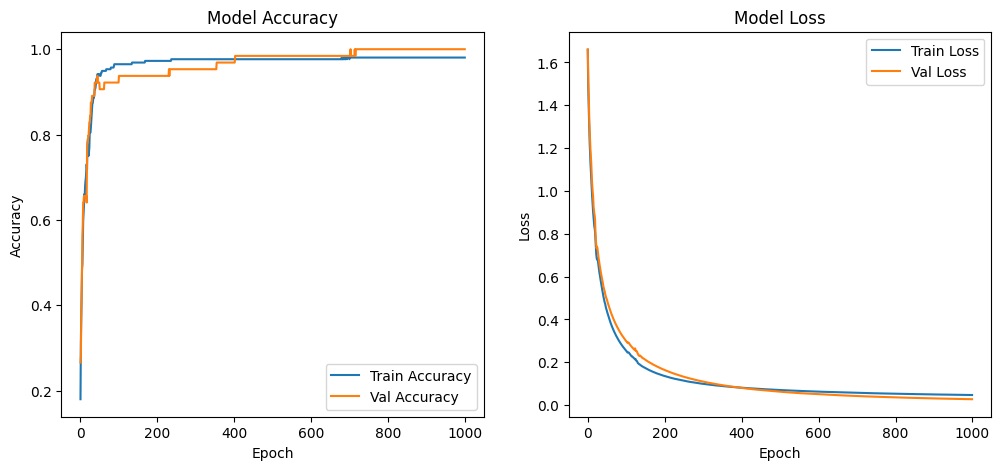

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

#plt.tight_layout()
if save_artifacts: plt.savefig(f"{filename}_train.png")
plt.show()


Optionally save the weights of the model

In [ ]:
# optionally save the model weights
if save_artifacts: model.save(f"{filename}.keras")

Evaluate model and print scores

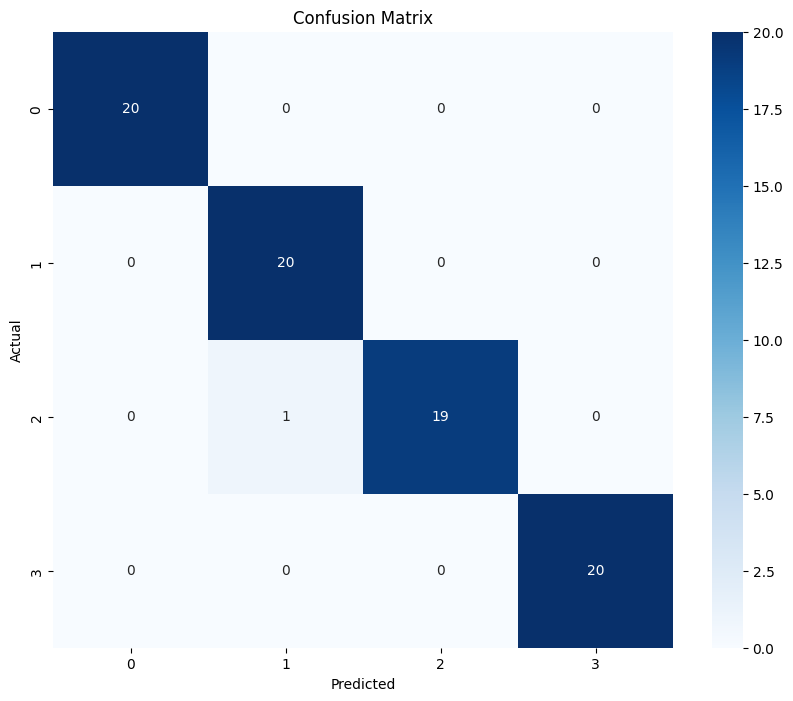

In [ ]:
if save_artifacts: 
    f = open(f"{filename}.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

# Summary of the model
model.summary(print_fn = f.write if save_artifacts else None)

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Classification report and F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
if save_artifacts: plt.savefig(f"{filename}-confusion_matrix.png")
plt.show()


# === Preview Predictions ===
for i in range(min(80, len(y_pred))):
    print(f"True: {y_test[i]}, Pred: {y_pred[i]}, Prob: {predictions[i]}")

if save_artifacts:
    sys.stdout = ostd
    f.close()


Test on larger test dataset (3 newest files)

In [10]:
import numpy as np
import random
import os
import tensorflow as tf
from preprocessor import Preprocessor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from test_models import load_model, test_random_line

In [ ]:
# preprocessor_path = "../data/preprocessors/preprocessor_20_smallest_files_100lpc_20ws_BERTencx16.zip"
test_preprocessor_path = "../data/preprocessors/preprocessor_3_newest_files_100lpc_20ws_BERTencx16.zip"
test_pp = Preprocessor.load(test_preprocessor_path)
print(test_pp.data.states_counts)
test_X, test_y = test_pp.data.as_xy_arrays()


defaultdict(<class 'int'>, {np.int64(0): 100, np.int64(3): 100, np.int64(2): 100, np.int64(1): 30})


In [12]:
# Get predictions
y_pred_probs = model.predict(test_X)
y_pred = y_pred_probs.argmax(axis=1)  # For softmax outputs

# True labels
y_true = test_y.argmax(axis=1) if test_y.ndim > 1 else test_y

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

if save_artifacts:
    f = open(f"{filename}-test.txt", "w")
    ostd = sys.stdout
    sys.stdout = f

print("test with test data (3 newest files)")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

if save_artifacts:
    f.close()
    sys.stdout = ostd

d:\mgeo\projects\log-classification\venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step


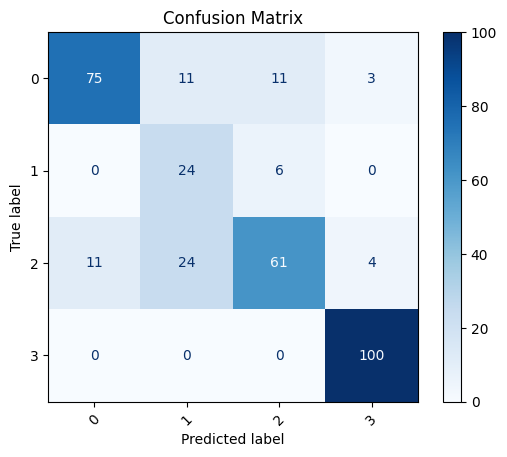

In [ ]:
# Compute and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig(f"{filename}-test_confusionmatrix.png")
plt.show()